In [1]:
import pandas as pd

# Load data
df = pd.read_csv('../data/clinvar_bc_annotated_canonical.txt', sep='\t', skiprows=93)

# Check contents and headings
print(df.columns.tolist())
print(df.head())

/tmp/ipykernel_1830/273539785.py:4: DtypeWarning: Columns (0,7,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/clinvar_bc_annotated_canonical.txt', sep='\t', skiprows=93)


['## VEP command-line: vep --assembly GRCh38 --cache --canonical --database 0 --dir_plugins [PATH]/Plugins --force_overwrite --input_file [PATH]/clinvar_bc_variants_for_vep.vcf --offline --output_file [PATH]/clinvar_bc_annotated_canonical.txt --plugin dbNSFP,[PATH]/dbNSFP5.1a_grch38.gz,SIFT_score,SIFT4G_score,PROVEAN_score,Polyphen2_HDIV_score,Polyphen2_HVAR_score,MutationTaster_score,MutationAssessor_score,fathmm-XF_coding_score,CADD_raw,VEST4_score,DANN_score,MetaSVM_score,MetaLR_score,MetaRNN_score,Eigen-raw_coding,Eigen-PC-raw_coding,M-CAP_score,REVEL_score,MutPred_score,MVP_score,gMVP_score,MPC_score,PrimateAI_score,DEOGEN2_score,BayesDel_addAF_score,BayesDel_noAF_score,ClinPred_score,LIST-S2_score,VARITY_R_score,VARITY_ER_score,VARITY_R_LOO_score,VARITY_ER_LOO_score,ESM1b_score,AlphaMissense_score,PHACTboost_score,MutFormer_score,MutScore_score,phyloP100way_vertebrate,phyloP470way_mammalian,phyloP17way_primate,phastCons100way_vertebrate,phastCons470way_mammalian,phastCons17way_pr

In [2]:
# Find header
with open('../data/clinvar_bc_annotated_canonical.txt') as f:
    for i, line in enumerate(f):
        if line.startswith('#') and not line.startswith('##'):
            header_line = i
            break

# Load data with correct header
df = pd.read_csv('../data/clinvar_bc_annotated_canonical.txt', sep='\t', skiprows=header_line + 1, header=None)

# Colomuns
with open('../data/clinvar_bc_annotated_canonical.txt') as f:
    lines = f.readlines()
    colnames = lines[header_line].lstrip('#').strip().split('\t')

df.columns = colnames

/tmp/ipykernel_1830/483758480.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/clinvar_bc_annotated_canonical.txt', sep='\t', skiprows=header_line + 1, header=None)


In [3]:
# Transcriptomic Harmonization
df = df[df['CANONICAL'] == 'YES']

# Population allele frequency filtering (MAF < 1%)
df['dbNSFP_POPMAX_AF'] = pd.to_numeric(df['dbNSFP_POPMAX_AF'], errors='coerce')

AF_threshold = 0.01
df_rare = df[df['dbNSFP_POPMAX_AF'] < AF_threshold]

print(f'There are {len(df_rare)} items after filtering')

There are 1329 items after filtering


In [4]:
# Deduplication

grouped = df_rare.groupby('Uploaded_variation')

sampled = grouped.apply(lambda x: x.sample(1), include_groups=False)

df_rare_unique = sampled.reset_index()

print(f"There are {len(df_rare_unique)} unique items after deduplication.")

There are 1329 unique items after deduplication.


In [5]:
# Keep missense variants in column Consequence
df_rare_unique_missense = df_rare_unique[df_rare_unique['Consequence'].str.contains('missense_variant')]

print(f"There are {len(df_rare_unique_missense)} missense SNVs.")

There are 519 missense SNVs.


## Binarization

In [6]:
# Extract infromation from the original dataset
from cyvcf2 import VCF

vcf_reader = VCF('../data/clinvar_bc_variants_for_vep.vcf')

records = []

for variant in vcf_reader:
    variant_id = variant.ID
    clnsig = variant.INFO.get('CLNSIG')

    records.append({
        'Uploaded_variation': variant_id,
        'ClinicalSignificance': clnsig
    })

clinvar_labels = pd.DataFrame(records)

print(clinvar_labels.head())
print(f"{len(clinvar_labels)} ClinVar labels are extracted.")


  Uploaded_variation          ClinicalSignificance
0             187213  Pathogenic/Likely_pathogenic
1             181942  Pathogenic/Likely_pathogenic
2            3148226                    Pathogenic
3             187275                    Pathogenic
4             188901  Pathogenic/Likely_pathogenic
12424 ClinVar labels are extracted.


In [7]:
# Merge rare variants and lables
## Check data type before mergeing
print(f"df_rare_unique_missense['Uploaded_variation'] dtype: {df_rare_unique_missense['Uploaded_variation'].dtype}")
print(f"clinvar_labels['Uploaded_variation'] dtype: {clinvar_labels['Uploaded_variation'].dtype}")


df_rare_unique_missense['Uploaded_variation'] dtype: int64
clinvar_labels['Uploaded_variation'] dtype: object


In [10]:
## Convert int64 to str
df_rare_unique_missense = df_rare_unique_missense.copy()
df_rare_unique_missense['Uploaded_variation'] = df_rare_unique_missense['Uploaded_variation'].astype(str)

clinvar_labels['Uploaded_variation'] = clinvar_labels['Uploaded_variation'].astype(str)

In [11]:
## Merge
df_merged = pd.merge(df_rare_unique_missense, clinvar_labels, on='Uploaded_variation', how='left')

print(f"There are {df_merged['ClinicalSignificance'].isna().sum()} variants without labels after merging.")

There are 0 variants without labels after merging.


In [12]:
# Binarization
## Define pathogenic and benign label sets
pathogenic_labels = ['Pathogenic', 'Likely_pathogenic', 'Pathogenic/Likely_pathogenic']
benign_labels = ['Benign', 'Likely_benign', 'Benign/Likely_benign']

def binarize_label(x):
    if pd.isna(x):
        return None
    x = str(x)
    if x in pathogenic_labels:
        return 1
    elif x in benign_labels:
        return 0
    else:
        return None  # VUS, Conflicting interpretations, Others

# Apply the binarization
df_merged['label'] = df_merged['ClinicalSignificance'].apply(binarize_label)

# Drop variants without a binary label
df_final = df_merged.dropna(subset=['label'])

print(f"There are {len(df_final)} variants with binary labels (0/1).")

# Save the final benchmark dataset
df_final.to_csv('../data/benchmark_dataset_canonical_raw.csv', index=False)

print("Benchmark dataset saved as benchmark_dataset_canonical_raw.csv!")


There are 519 variants with binary labels (0/1).
Benchmark dataset saved as benchmark_dataset_canonical_raw.csv!


## Visualization

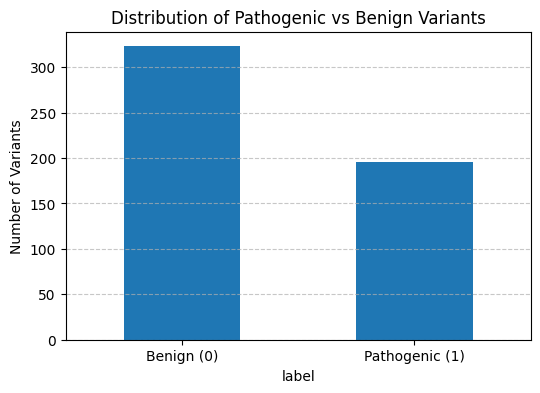

In [13]:
# Visualization
import matplotlib.pyplot as plt

## Load data
df = pd.read_csv('../data/benchmark_dataset_canonical_raw.csv')

## Histgram of distribution
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar')
plt.xticks([0, 1], ['Benign (0)', 'Pathogenic (1)'], rotation=0)
plt.ylabel('Number of Variants')
plt.title('Distribution of Pathogenic vs Benign Variants')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Data cleansing

In [14]:
# Load the raw dataset
df = pd.read_csv('../data/benchmark_dataset_canonical_raw.csv')

# Define cleasing function
def clean_score(x):
    if pd.isna(x):
        return None
    items = str(x).split(',')
    numbers = []
    for i in items:
        if i not in ['.', '-', '']:
            try:
                numbers.append(float(i))
            except ValueError:
                continue
    if len(numbers) > 0:
        return numbers[0]  # Reserve the first score
    else:
        return None

# Define score list
score_columns = [
    'SIFT_score', 'SIFT4G_score', 'PROVEAN_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score',
    'MutationTaster_score', 'MutationAssessor_score', 'fathmm-XF_coding_score', 'CADD_raw',
    'VEST4_score', 'DANN_score', 'MetaSVM_score', 'MetaLR_score', 'MetaRNN_score',
    'Eigen-raw_coding', 'Eigen-PC-raw_coding', 'M-CAP_score', 'REVEL_score', 'MutPred_score',
    'MVP_score', 'gMVP_score', 'MPC_score', 'PrimateAI_score', 'DEOGEN2_score',
    'BayesDel_addAF_score', 'BayesDel_noAF_score', 'ClinPred_score', 'LIST-S2_score',
    'VARITY_R_score', 'VARITY_ER_score', 'VARITY_R_LOO_score', 'VARITY_ER_LOO_score',
    'ESM1b_score', 'AlphaMissense_score', 'PHACTboost_score', 'MutFormer_score', 'MutScore_score',
    'phyloP100way_vertebrate', 'phyloP470way_mammalian', 'phyloP17way_primate',
    'phastCons100way_vertebrate', 'phastCons470way_mammalian', 'phastCons17way_primate',
    'bStatistic', 'GERP++_RS', 'GERP_91_mammals', '1000Gp3_AF', 'gnomAD4.1_joint_AF',
    'TOPMed_frz8_AF', 'AllofUs_ALL_AF', 'RegeneronME_ALL_AF', 'dbNSFP_POPMAX_AF'
]

# Cleansing
for col in score_columns:
    if col in df.columns:
        print(f"Cleaning {col}...")
        df[col] = df[col].apply(clean_score) ## Avoid key error
    else:
        print(f"Warning: {col} not found in DataFrame, skipping.")

# Save the dataset
df.to_csv('../data/benchmark_dataset_canonical_cleaned.csv', index=False)

print("Cleaned dataset saved as benchmark_dataset_canonical_cleaned.csv")


Cleaning SIFT_score...
Cleaning SIFT4G_score...
Cleaning PROVEAN_score...
Cleaning Polyphen2_HDIV_score...
Cleaning Polyphen2_HVAR_score...
Cleaning MutationTaster_score...
Cleaning MutationAssessor_score...
Cleaning fathmm-XF_coding_score...
Cleaning CADD_raw...
Cleaning VEST4_score...
Cleaning DANN_score...
Cleaning MetaSVM_score...
Cleaning MetaLR_score...
Cleaning MetaRNN_score...
Cleaning Eigen-raw_coding...
Cleaning Eigen-PC-raw_coding...
Cleaning M-CAP_score...
Cleaning REVEL_score...
Cleaning MutPred_score...
Cleaning MVP_score...
Cleaning gMVP_score...
Cleaning MPC_score...
Cleaning PrimateAI_score...
Cleaning DEOGEN2_score...
Cleaning BayesDel_addAF_score...
Cleaning BayesDel_noAF_score...
Cleaning ClinPred_score...
Cleaning LIST-S2_score...
Cleaning VARITY_R_score...
Cleaning VARITY_ER_score...
Cleaning VARITY_R_LOO_score...
Cleaning VARITY_ER_LOO_score...
Cleaning ESM1b_score...
Cleaning AlphaMissense_score...
Cleaning PHACTboost_score...
Cleaning MutFormer_score...
Cleanin

## Impute missing value

In [16]:
# Load the dataset
df_cleaned = pd.read_csv('../data/benchmark_dataset_canonical_cleaned.csv')

# Missing value stastics
pd.set_option('display.max_rows', None)

missing_summary = df_cleaned.isnull().sum()

# Sort the result
missing_summary = missing_summary.sort_values(ascending=False)

print(missing_summary)


1000Gp3_AF                    427
MutPred_score                 236
TOPMed_frz8_AF                214
VARITY_ER_LOO_score           193
VARITY_ER_score               193
VARITY_R_score                193
VARITY_R_LOO_score            193
LIST-S2_score                 192
PHACTboost_score              192
AllofUs_ALL_AF                148
GERP_91_mammals               100
RegeneronME_ALL_AF             87
gnomAD4.1_joint_AF             72
MutationTaster_score           41
MutationAssessor_score          8
MVP_score                       3
MutScore_score                  2
MutFormer_score                 2
M-CAP_score                     2
DANN_score                      1
Polyphen2_HDIV_score            1
MetaSVM_score                   1
PROVEAN_score                   1
Polyphen2_HVAR_score            1
BayesDel_addAF_score            1
REVEL_score                     1
SIFT_score                      1
fathmm-XF_coding_score          1
PrimateAI_score                 1
Eigen-raw_codi

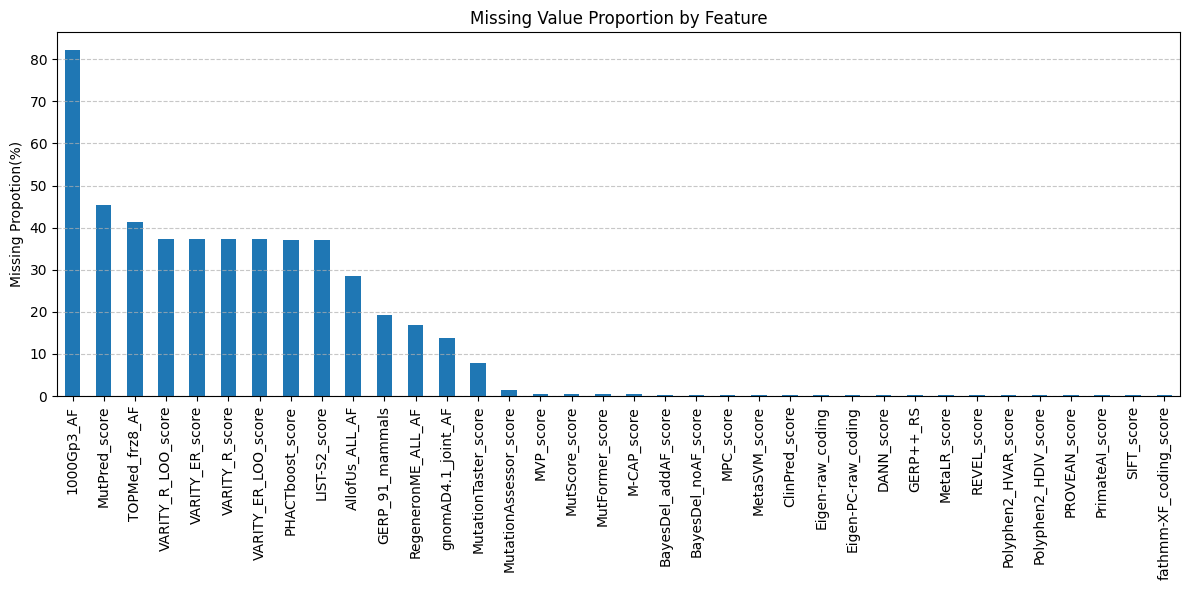

In [17]:
df_cleaned = pd.read_csv('../data/benchmark_dataset_canonical_cleaned.csv')

# Calculate the proportion
missing_proportion = df_cleaned.isnull().sum() / len(df_cleaned) * 100
missing_proportion = missing_proportion[missing_proportion > 0]
missing_proportion = missing_proportion.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
missing_proportion.plot(kind='bar')
plt.ylabel('Missing Propotion(%)')
plt.title('Missing Value Proportion by Feature')
plt.xticks(rotation=90)
plt.grid(axis= 'y', ls='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
# Drop columns with too many missing values
drop_cols = [
    '1000Gp3_AF', 'MutPred_score', 'TOPMed_frz8_AF',
    'VARITY_ER_score', 'VARITY_R_score', 'VARITY_R_LOO_score', 
    'VARITY_ER_LOO_score', 'PHACTboost_score', 'LIST-S2_score'
]

df_cleaned.drop(columns=drop_cols, inplace=True)

In [19]:
# Fill other missing values with median
fill_cols = [col for col in df_cleaned.columns if df_cleaned[col].isnull().sum() > 0]

for col in fill_cols:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)
    print(f"Filled missing values in '{col}' with median value.")

df_cleaned.to_csv('../data/benchmark_dataset.csv', index=False)

print("Saved final cleaned dataset as 'benchmark_dataset.csv'")

Filled missing values in 'AllofUs_ALL_AF' with median value.
Filled missing values in 'BayesDel_addAF_score' with median value.
Filled missing values in 'BayesDel_noAF_score' with median value.
Filled missing values in 'ClinPred_score' with median value.
Filled missing values in 'DANN_score' with median value.
Filled missing values in 'Eigen-PC-raw_coding' with median value.
Filled missing values in 'Eigen-raw_coding' with median value.
Filled missing values in 'GERP++_RS' with median value.
Filled missing values in 'GERP_91_mammals' with median value.
Filled missing values in 'M-CAP_score' with median value.
Filled missing values in 'MPC_score' with median value.
Filled missing values in 'MVP_score' with median value.
Filled missing values in 'MetaLR_score' with median value.
Filled missing values in 'MetaSVM_score' with median value.
Filled missing values in 'MutFormer_score' with median value.
Filled missing values in 'MutScore_score' with median value.
Filled missing values in 'Mut

## Split training and testing sets

In [20]:
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('../data/benchmark_dataset.csv')

# Define feature columns and label
X = df.drop(columns=[
    'label'
])
y = df['label'].astype(int)

# Split datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Merge
train_df = X_train.copy()
train_df['label'] = y_train

test_df = X_test.copy()
test_df['label'] = y_test

# Save
train_df.to_csv('../data/training_set.csv', index=False)
test_df.to_csv('../data/test_set.csv', index=False)

# Check the results
print(f"Split is done, size of training set is {len(train_df)}, size of testing set is {len(test_df)}.")
print(f"Labels are distributed in the training set: \n{y_train.value_counts(normalize=True)}")
print(f"Labels are distributed in the training set: \n{y_test.value_counts(normalize=True)}")
print(y_train.dtypes)

Split is done, size of training set is 415, size of testing set is 104.
Labels are distributed in the training set: 
label
0    0.621687
1    0.378313
Name: proportion, dtype: float64
Labels are distributed in the training set: 
label
0    0.625
1    0.375
Name: proportion, dtype: float64
int64


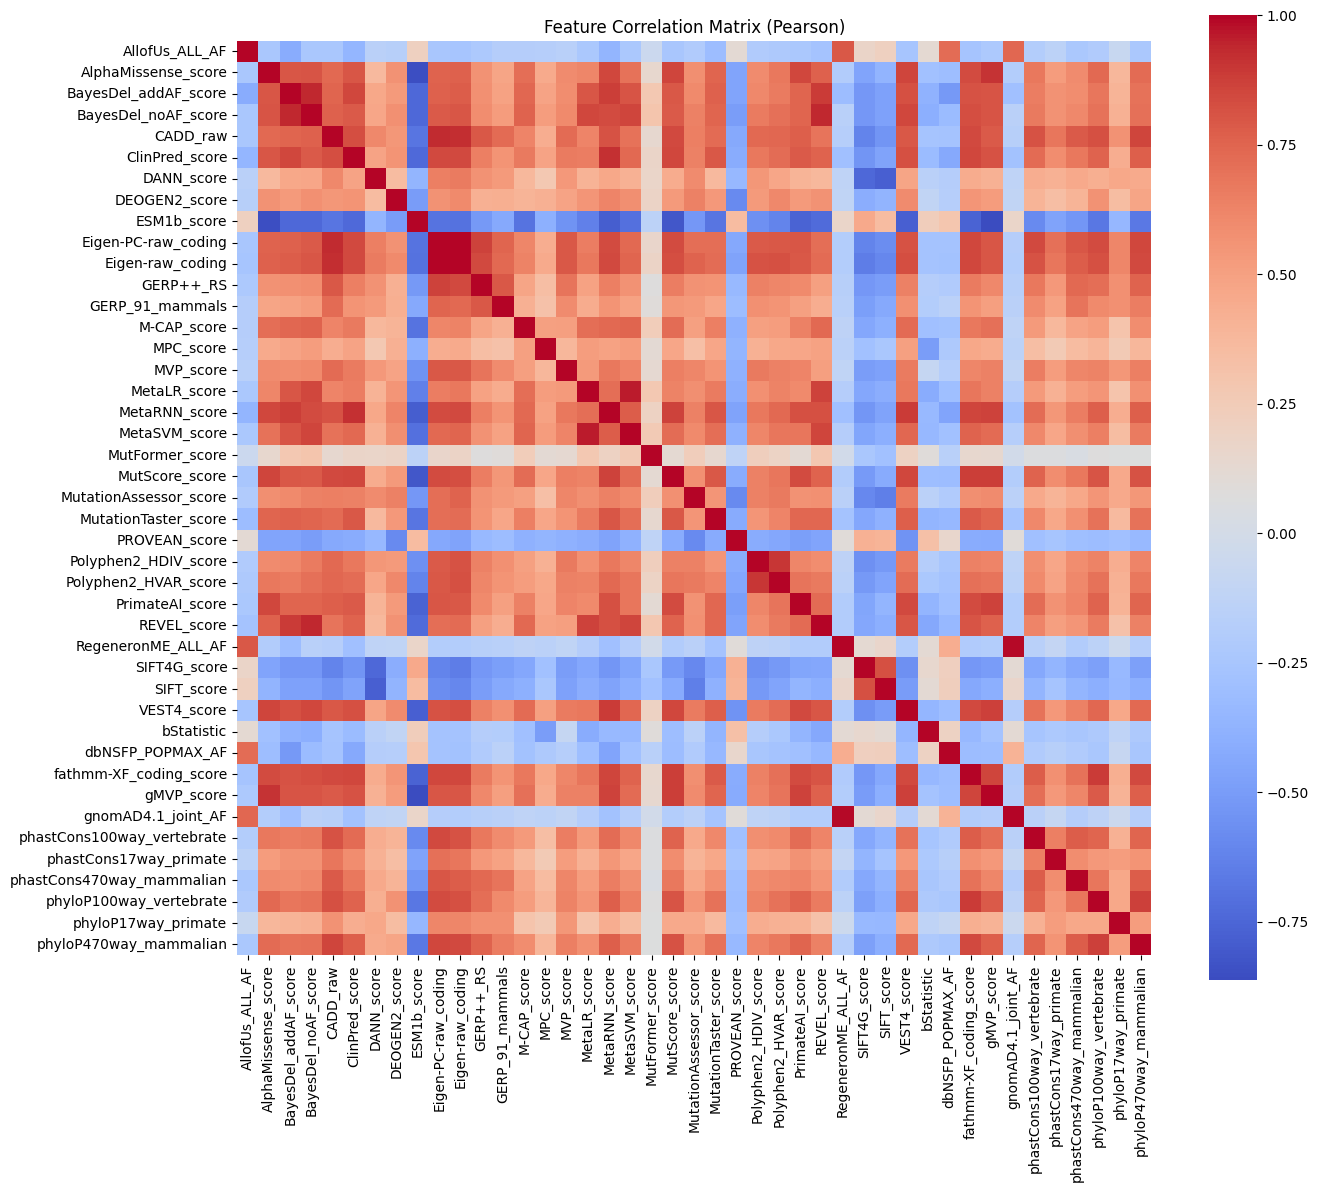

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the benchmark dataset
df = pd.read_csv("../data/benchmark_dataset.csv")

# Columns to exclude
exclude_cols = [
    'Uploaded_variation', 'level_1', 'Location', 'Allele', 'Gene',
    'Feature', 'Feature_type', 'Consequence',
    'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids',
    'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE',
    'STRAND', 'FLAGS', 'ClinicalSignificance', 'label', 'CANONICAL'
]

# Select only numeric features excluding the ones listed
df_numeric = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors='ignore')
df_numeric = df_numeric.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = df_numeric.corr(method='pearson')

# Plot the correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True)
plt.title("Feature Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()


In [2]:
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper_triangle.stack().sort_values(ascending=False)
high_corr_pairs_filtered = high_corr_pairs[high_corr_pairs > 0.8]

df_display = high_corr_pairs_filtered.reset_index()
df_display.columns = ['Feature 1', 'Feature 2', 'Correlation']
display(df_display)

df_display.to_csv("../highly_correlated_features.csv", index=False)
print("highly_correlated_features.csv has been saved.")

,Feature 1,Feature 2,Correlation
0,Eigen-PC-raw_coding,Eigen-raw_coding,0.995486
1,RegeneronME_ALL_AF,gnomAD4.1_joint_AF,0.990853
2,MetaLR_score,MetaSVM_score,0.958794
3,BayesDel_noAF_score,REVEL_score,0.936492
4,BayesDel_addAF_score,BayesDel_noAF_score,0.935767
...,...,...,...
86,AlphaMissense_score,ClinPred_score,0.803037
87,AlphaMissense_score,BayesDel_addAF_score,0.802529
88,MetaRNN_score,MutationTaster_score,0.800837
89,Eigen-PC-raw_coding,gMVP_score,0.800812


highly_correlated_features.csv has been saved.


In [16]:
# Load the CSV file
df_corr = pd.read_csv("../highly_correlated_features.csv")

# Extract unique feature names from both columns
feature_set = set(df_corr['Feature 1']).union(set(df_corr['Feature 2']))

# Convert to sorted list for readability
sorted_feature_list = sorted(feature_set)

# Display the feature list
sorted_feature_list


['AlphaMissense_score',
 'BayesDel_addAF_score',
 'BayesDel_noAF_score',
 'CADD_raw',
 'ClinPred_score',
 'Eigen-PC-raw_coding',
 'Eigen-raw_coding',
 'GERP++_RS',
 'MetaLR_score',
 'MetaRNN_score',
 'MetaSVM_score',
 'MutScore_score',
 'MutationTaster_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'PrimateAI_score',
 'REVEL_score',
 'RegeneronME_ALL_AF',
 'SIFT4G_score',
 'SIFT_score',
 'VEST4_score',
 'fathmm-XF_coding_score',
 'gMVP_score',
 'gnomAD4.1_joint_AF',
 'phastCons100way_vertebrate',
 'phyloP100way_vertebrate',
 'phyloP470way_mammalian']

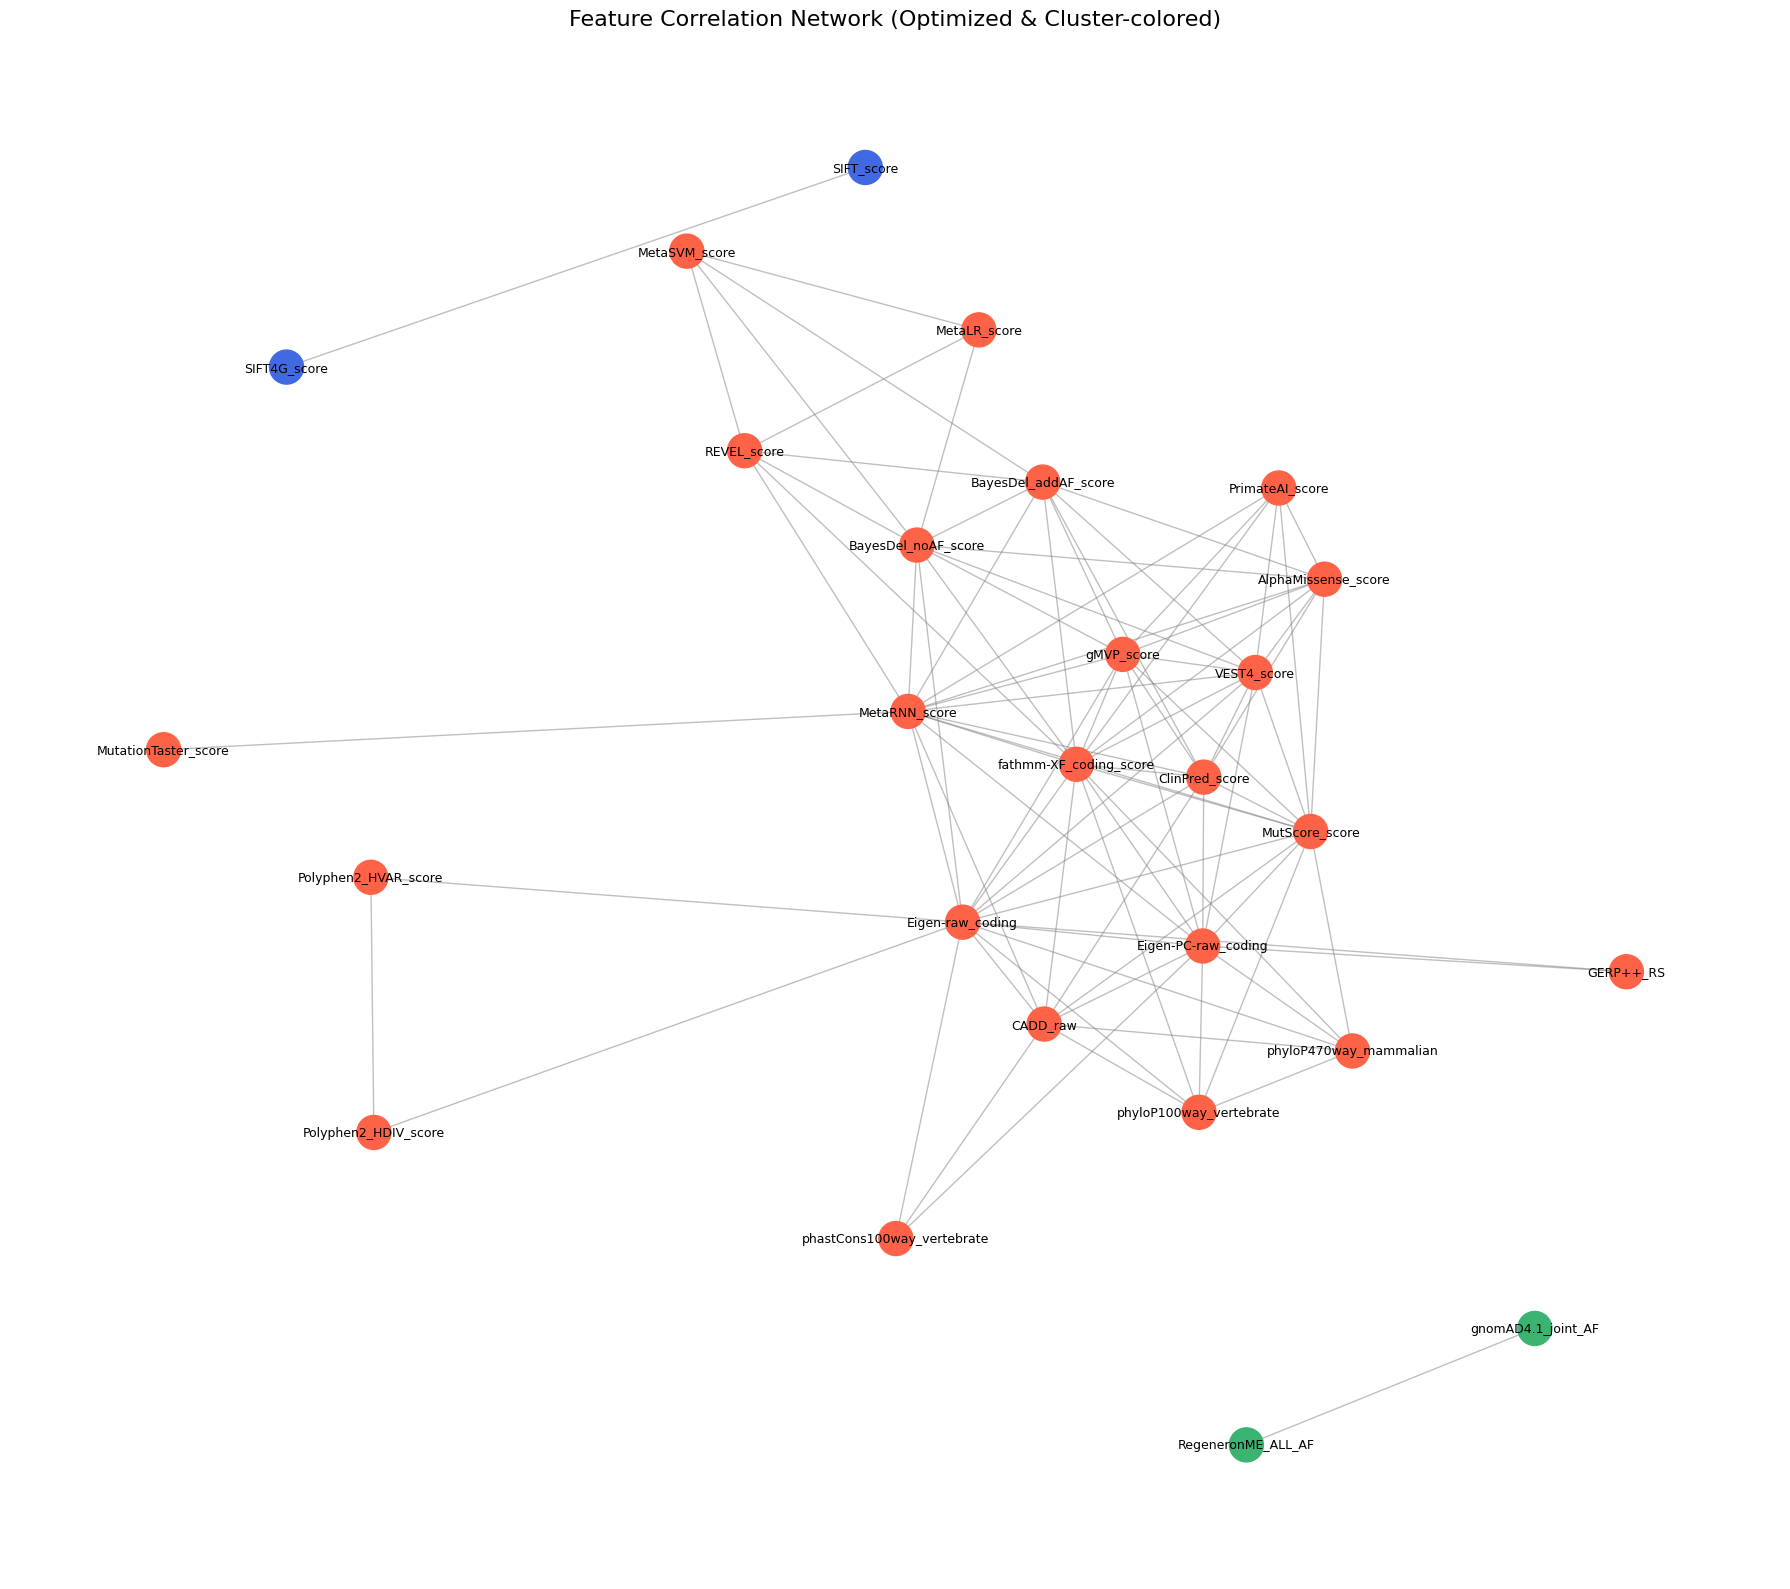

In [17]:
import networkx as nx

# Create a graph
G = nx.Graph()
for _, row in df_corr.iterrows():
    G.add_edge(row['Feature 1'], row['Feature 2'])

# Make nodes and edges
components = list(nx.connected_components(G))
sorted_components = sorted(components, key=len, reverse=True)
palette = ['tomato', 'mediumseagreen', 'royalblue']
color_map = []
for node in G.nodes():
    for idx, comp in enumerate(sorted_components[:3]):
        if node in comp:
            color_map.append(palette[idx])
            break
    else:
        color_map.append('gray')

# Configurartion
pos_final = nx.spring_layout(G, k=3.2, iterations=230, scale=4, seed=2025)

# Plot
plt.figure(figsize=(18, 16))
nx.draw_networkx_nodes(G, pos_final, node_size=600, node_color=color_map)
nx.draw_networkx_labels(G, pos_final, font_size=9)
nx.draw_networkx_edges(G, pos_final, edge_color='gray', alpha=0.5)
plt.title("Feature Correlation Network (Optimized & Cluster-colored)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [20]:
# Find connected components (each is a high-correlation group)
components = list(nx.connected_components(G))

# Display each group with its feature names
for idx, comp in enumerate(components, start=1):
    print(f"Group {idx} (size={len(comp)}):")
    for feat in sorted(comp):
        print(f"  - {feat}")
    print()

Group 1 (size=23):
  - AlphaMissense_score
  - BayesDel_addAF_score
  - BayesDel_noAF_score
  - CADD_raw
  - ClinPred_score
  - Eigen-PC-raw_coding
  - Eigen-raw_coding
  - GERP++_RS
  - MetaLR_score
  - MetaRNN_score
  - MetaSVM_score
  - MutScore_score
  - MutationTaster_score
  - Polyphen2_HDIV_score
  - Polyphen2_HVAR_score
  - PrimateAI_score
  - REVEL_score
  - VEST4_score
  - fathmm-XF_coding_score
  - gMVP_score
  - phastCons100way_vertebrate
  - phyloP100way_vertebrate
  - phyloP470way_mammalian

Group 2 (size=2):
  - RegeneronME_ALL_AF
  - gnomAD4.1_joint_AF

Group 3 (size=2):
  - SIFT4G_score
  - SIFT_score



In [18]:
# Identify the largest connected component (orange group)
components = list(nx.connected_components(G))
largest_comp = max(components, key=len)
subG = G.subgraph(largest_comp)

# Greedy approximation of minimum dominating set on subgraph
uncovered = set(subG.nodes())
dominating_set = set()
while uncovered:
    # Select node covering the most uncovered nodes (including itself)
    best_node = max(subG.nodes(),
                    key=lambda n: len(set(subG.neighbors(n)).union({n}) & uncovered))
    dominating_set.add(best_node)
    # Remove covered nodes
    covered = set(subG.neighbors(best_node)) | {best_node}
    uncovered -= covered

# Display the result without ace_tools
df_dom = pd.DataFrame({"Dominating Node": list(dominating_set)})
display(df_dom)


,Dominating Node
0,Eigen-raw_coding
1,BayesDel_noAF_score
2,MetaRNN_score
